In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/nemolinux/Python/sam2/notebooks


In [19]:

!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [2]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [3]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [4]:
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

CONFIG_DIRECTORY = "configs/sam2"  # Adjust this relative path as necessary
CONFIG = "sam2_hiera_l.yaml"

# Clear existing Hydra instance (if any) and initialize it
GlobalHydra.instance().clear()
initialize(config_path=CONFIG_DIRECTORY, version_base=None)

# Compose the configuration
cfg = compose(config_name=CONFIG)
print(f"Hydra configuration loaded successfully:\n{cfg}")


Hydra configuration loaded successfully:
{'model': {'_target_': 'sam2.modeling.sam2_base.SAM2Base', 'image_encoder': {'_target_': 'sam2.modeling.backbones.image_encoder.ImageEncoder', 'scalp': 1, 'trunk': {'_target_': 'sam2.modeling.backbones.hieradet.Hiera', 'embed_dim': 144, 'num_heads': 2, 'stages': [2, 6, 36, 4], 'global_att_blocks': [23, 33, 43], 'window_pos_embed_bkg_spatial_size': [7, 7], 'window_spec': [8, 4, 16, 8]}, 'neck': {'_target_': 'sam2.modeling.backbones.image_encoder.FpnNeck', 'position_encoding': {'_target_': 'sam2.modeling.position_encoding.PositionEmbeddingSine', 'num_pos_feats': 256, 'normalize': True, 'scale': None, 'temperature': 10000}, 'd_model': 256, 'backbone_channel_list': [1152, 576, 288, 144], 'fpn_top_down_levels': [2, 3], 'fpn_interp_model': 'nearest'}}, 'memory_attention': {'_target_': 'sam2.modeling.memory_attention.MemoryAttention', 'd_model': 256, 'pos_enc_at_input': True, 'layer': {'_target_': 'sam2.modeling.memory_attention.MemoryAttentionLayer', 

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
#CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

In [6]:
predictor = SAM2ImagePredictor(sam2_model)

In [55]:
IMAGE_PATH = f"{HOME}/image_SEM/original_images/soil_extracts/sample8_03.tif"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

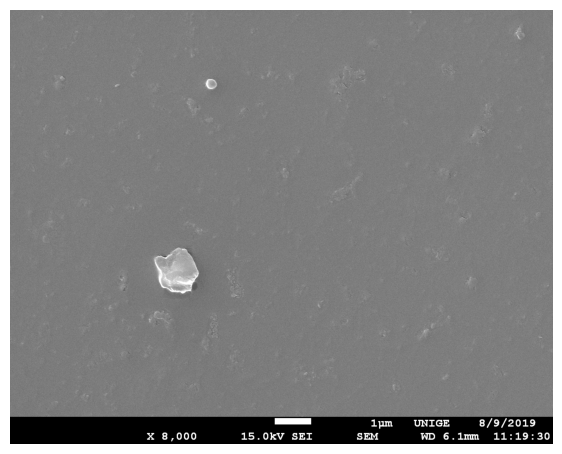

In [56]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(7, 7))
plt.imshow(image_bgr)
plt.axis('off')
plt.show()

In [57]:
# Encode image function
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64," + encoded

In [58]:
# Initialize bounding box parameters
start_point = None
#end_point = None
drawing = False
bounding_boxes = []

In [59]:
# Function to draw a rectangle on the image
def draw_rectangle(event, x, y, flags, param):
    global drawing, start_point, image_bgr

    if event == cv2.EVENT_LBUTTONDOWN:  # Start drawing
        drawing = True
        start_point = (x, y)

    elif event == cv2.EVENT_MOUSEMOVE:  # Update rectangle while dragging
        if drawing:
            # Draw the rectangle on a temporary image to show while dragging
            temp_image = image_bgr.copy()
            cv2.rectangle(temp_image, start_point, (x, y), (0, 255, 0), 2)
            cv2.imshow("Draw Bounding Boxes", temp_image)

    elif event == cv2.EVENT_LBUTTONUP:  # Finish drawing
        drawing = False
        end_point = (x, y)
        x1, y1 = start_point
        x2, y2 = end_point
        bounding_boxes.append({
            'x': min(x1, x2),
            'y': min(y1, y2),
            'width': abs(x2 - x1),
            'height': abs(y2 - y1)
        })
        # Draw the final rectangle on the original image
        cv2.rectangle(image_bgr, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow("Draw Bounding Boxes", image_bgr)


In [60]:
# Function to redraw the image with all bounding boxes
def redraw_image():
    temp_image = original_image.copy()
    for box in bounding_boxes:
        x, y, width, height = box['x'], box['y'], box['width'], box['height']
        cv2.rectangle(temp_image, (x, y), (x + width, y + height), (0, 255, 0), 2)
    cv2.imshow("Draw Bounding Boxes", temp_image)

In [61]:
# updated_version_Load image and create a copy for reset
IMAGE_PATH = f"{HOME}/image_SEM/original_images/soil_extracts/sample8_03.tif"
image_bgr = cv2.imread(IMAGE_PATH)
original_image = image_bgr.copy()

In [62]:
# Set up OpenCV window and mouse callback
cv2.namedWindow("Draw Bounding Boxes", cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Draw Bounding Boxes", draw_rectangle)

print("Use your mouse to draw bounding boxes. Press 'd' to delete the last box, 'r' to reset all boxes, and 'q' to finish.")

while True:
    # Display the image with bounding boxes
    cv2.imshow("Draw Bounding Boxes", image_bgr)

    # Wait for key press and handle events
    key = cv2.waitKey(10) & 0xFF  # Increase wait time for better event handling

    if key == ord('q'):  # Quit the loop
        break
    elif key == ord('d') and bounding_boxes:  # Delete the last bounding box
        bounding_boxes.pop()
        redraw_image()
    elif key == ord('r'):  # Reset all bounding boxes
        bounding_boxes.clear()
        image_bgr = original_image.copy()
        cv2.imshow("Draw Bounding Boxes", image_bgr)

cv2.destroyAllWindows()

Use your mouse to draw bounding boxes. Press 'd' to delete the last box, 'r' to reset all boxes, and 'q' to finish.


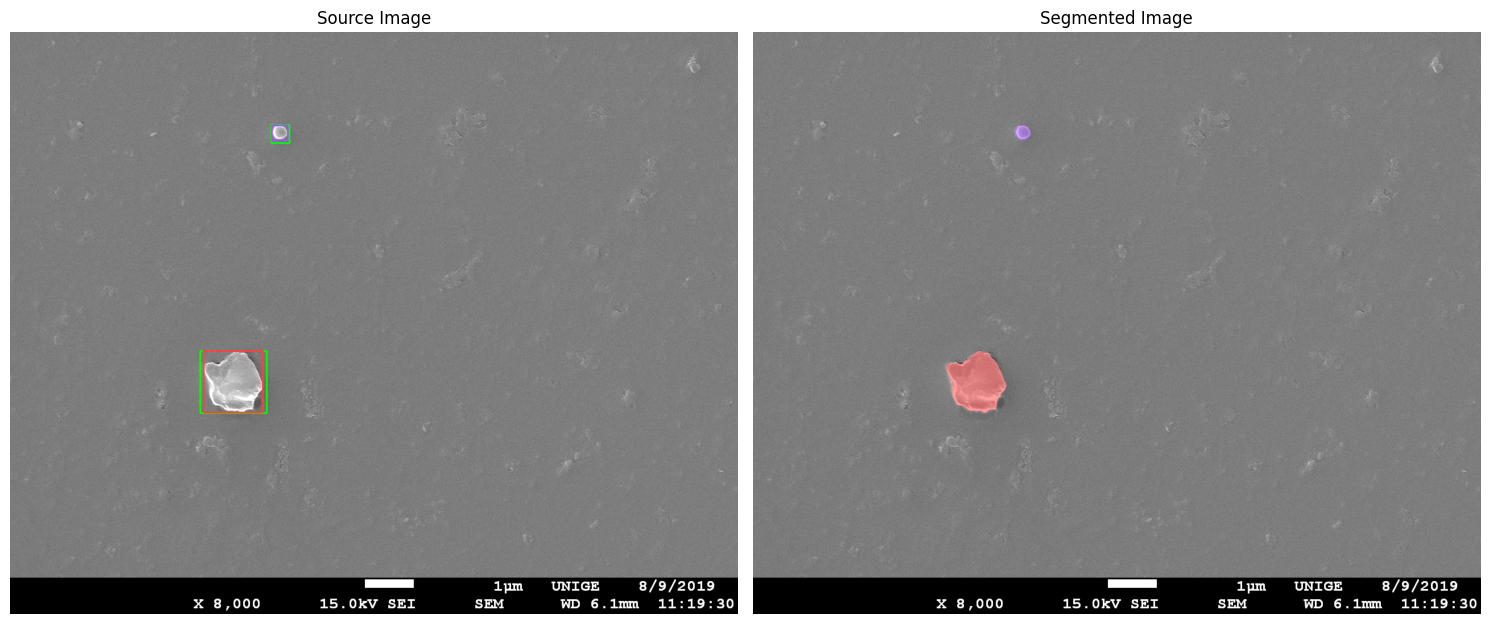

In [63]:
if len(bounding_boxes) == 0:
    print("No bounding boxes were drawn. Exiting.")
else:
    # Convert bounding_boxes (from OpenCV) to the format used by the predictor
    boxes = np.array([
        [
            box['x'],
            box['y'],
            box['x'] + box['width'],
            box['y'] + box['height']
        ]
        for box in bounding_boxes
    ])

    # Set the image for the predictor
    predictor.set_image(image_rgb)



    # Predict masks based on the drawn boxes
    masks, scores, logits = predictor.predict(
        box=boxes,
        multimask_output=False
    )

    # Adjust masks based on the number of boxes
    if boxes.shape[0] != 1:
        masks = np.squeeze(masks)

    # Create annotators for visualizing results
    box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

    # Generate detections from masks
    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks),
        mask=masks.astype(bool)
    )

    # Create the source image with bounding boxes
    source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)

    # Create the segmented image without bounding boxes
    segmented_image = mask_annotator.annotate(scene=original_image.copy(), detections=detections)

    # Plot the results side by side
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    # Display the source image with bounding boxes
    ax[0].imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))
    ax[0].axis('off')
    ax[0].set_title('Source Image')

    # Display the segmented image without bounding boxes
    ax[1].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    ax[1].axis('off')
    ax[1].set_title('Segmented Image')

    plt.tight_layout()
    plt.show()


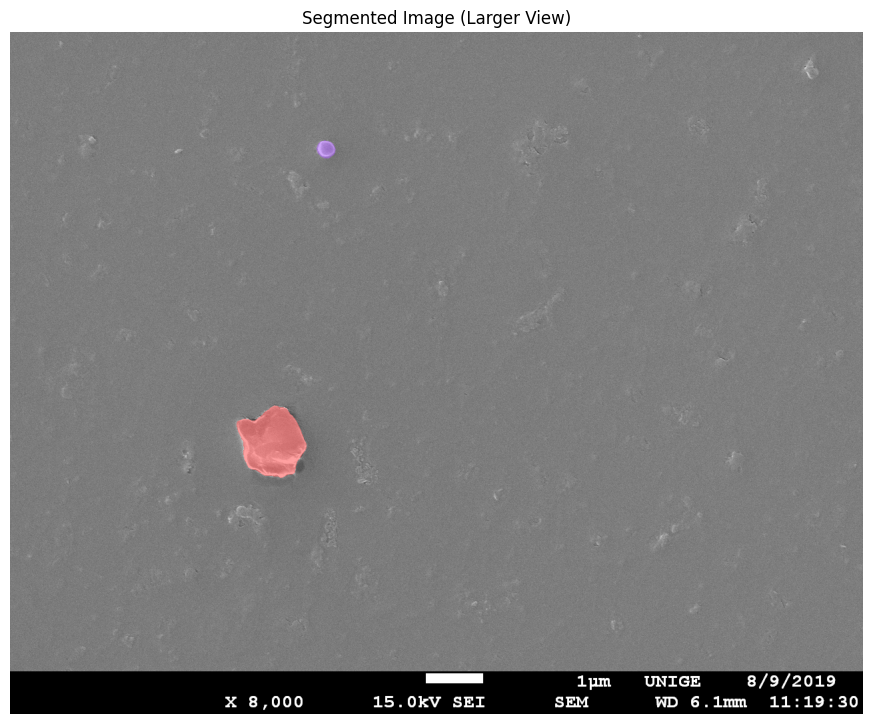

In [64]:
# Plot the segmented image in a larger size
fig, ax = plt.subplots(figsize=(11, 11))  # Increase the size of the plot
ax.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
ax.axis('off')  # Hide axes
ax.set_title('Segmented Image (Larger View)')  # Set title
plt.show()  # Display the image

In [65]:
import os
import cv2

save_folder = "/home/nemolinux/Python/sam2/notebooks/image_SEM/segmented_images/soil_extracts"


# Ensure the folder exists
os.makedirs(save_folder, exist_ok=True)

# Define the path to save the image
save_path = os.path.join(save_folder, "sample8_03.jpg")

# Save the image using OpenC
cv2.imwrite(save_path, segmented_image)

print(f"Annotated image saved to {save_path}")

Annotated image saved to /home/nemolinux/Python/sam2/notebooks/image_SEM/segmented_images/soil_extracts/sample8_03.jpg
